In [116]:
import numpy as np
import matplotlib.pyplot as plt
# import io
# import boto3

import pandas as pd
import math

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

import warnings
warnings.filterwarnings('ignore')

In [117]:
%%time
full_df = pd.read_csv(r"C:\Users\canel\Desktop\craigslist_used_cars_full.csv")
full_df.shape

CPU times: total: 33.8 s
Wall time: 35.3 s


(426880, 26)

In [118]:
full_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [119]:
nan_counts = full_df.isna().sum()
print("Number of NaN's per columns:\n", nan_counts)    

Number of NaN's per columns:
 id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64


In [120]:
non_nan_counts = full_df.shape[0] - nan_counts
nan_percent = (nan_counts/full_df.shape[0]) * 100
nan_summary = pd.DataFrame({'nan_count': nan_counts, 'nan_pct': nan_percent, 'non_nan_count': non_nan_counts})

print(nan_summary.sort_values('nan_pct', ascending=True))

              nan_count  nan_pct  non_nan_count
id                    0    0.000         426880
url                   0    0.000         426880
region                0    0.000         426880
region_url            0    0.000         426880
price                 0    0.000         426880
state                 0    0.000         426880
image_url            68    0.016         426812
posting_date         68    0.016         426812
description          70    0.016         426810
year               1205    0.282         425675
transmission       2556    0.599         424324
fuel               3013    0.706         423867
odometer           4400    1.031         422480
model              5277    1.236         421603
lat                6549    1.534         420331
long               6549    1.534         420331
title_status       8242    1.931         418638
manufacturer      17646    4.134         409234
type              92858   21.753         334022
paint_color      130203   30.501        

In [121]:
df = full_df.drop(columns=['county', 'size', 'VIN', 'url', 'id', 'image_url', 'region_url', 'description'])

In [122]:
# --- Define the list of all categorical columns you plan to modify ---
categorical_cols = [
    'cylinders',
    'manufacturer',
    'model',
    'condition',
    'fuel',
    'title_status',
    'transmission',
    'drive',
    'type',
    'paint_color'
]

# --- 1. Conditionally Impute 'cylinders' based on 'model' ---
print("Imputing 'cylinders'...")
# Create a series where each model's NaN is filled with that model's cylinder mode
# The transform function broadcasts the result of the group operation back to the original shape
# The lambda function is wrapped to handle models where cylinder info is entirely missing
cylinder_impute_values = df.groupby('model')['cylinders'].transform(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
)

# Fill the NaNs using the created series
df['cylinders'].fillna(cylinder_impute_values, inplace=True)

# Any remaining NaNs are for models that had no cylinder data, fill them with 'Missing'
df['cylinders'].fillna('Missing', inplace=True)


# --- 2. Conditionally Impute 'manufacturer' based on 'model' ---
print("Imputing 'manufacturer'...")
# This is even more reliable, as a model should only have one manufacturer
manufacturer_impute_values = df.groupby('model')['manufacturer'].transform(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
)
df['manufacturer'].fillna(manufacturer_impute_values, inplace=True)
df['manufacturer'].fillna('Missing', inplace=True) # Fallback for any leftovers


# --- 3. Impute the Rest of the Categorical Columns with 'Missing' ---
print("Imputing remaining categorical columns...")
other_categorical_cols = [
    'condition',
    'fuel',
    'title_status',
    'transmission',
    'drive',
    'type',
    'paint_color'
]

for col in other_categorical_cols:
    df[col].fillna('not_available', inplace=True)

print("\nNaN counts after conditional imputation:")
print(df[categorical_cols].isna().sum()) # Re-using the list from the previous answer

Imputing 'cylinders'...
Imputing 'manufacturer'...
Imputing remaining categorical columns...

NaN counts after conditional imputation:
cylinders          0
manufacturer       0
model           5277
condition          0
fuel               0
title_status       0
transmission       0
drive              0
type               0
paint_color        0
dtype: int64


In [123]:
numerical_cols = ['year', 'odometer', 'lat', 'long']
for col in numerical_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

In [124]:
df.isna().sum()

region             0
price              0
year               0
manufacturer       0
model           5277
condition          0
cylinders          0
fuel               0
odometer           0
title_status       0
transmission       0
drive              0
type               0
paint_color        0
state              0
lat                0
long               0
posting_date      68
dtype: int64

In [125]:
df = df.dropna()

In [126]:
df.shape

(421603, 18)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421603 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        421603 non-null  object 
 1   price         421603 non-null  int64  
 2   year          421603 non-null  float64
 3   manufacturer  421603 non-null  object 
 4   model         421603 non-null  object 
 5   condition     421603 non-null  object 
 6   cylinders     421603 non-null  object 
 7   fuel          421603 non-null  object 
 8   odometer      421603 non-null  float64
 9   title_status  421603 non-null  object 
 10  transmission  421603 non-null  object 
 11  drive         421603 non-null  object 
 12  type          421603 non-null  object 
 13  paint_color   421603 non-null  object 
 14  state         421603 non-null  object 
 15  lat           421603 non-null  float64
 16  long          421603 non-null  float64
 17  posting_date  421603 non-null  object 
dtypes: 

In [128]:
df['year'] = df['year'].astype(int)
df['odometer'] = df['odometer'].astype(int)

In [129]:
odometer_cap = df['odometer'].quantile(0.995)
print(f"Setting the maximum odometer for the plot at: {int(odometer_cap)}")

# 2. Create a filtered view of the DataFrame for plotting
df = df[df['odometer'] < odometer_cap]


price_cap = df['price'].quantile(0.995)
print(f"Setting the maximum price for the plot at: {int(price_cap)}")

# 2. Create a filtered view of the DataFrame for plotting
df = df[df['price'] < price_cap]

Setting the maximum odometer for the plot at: 344000
Setting the maximum price for the plot at: 75000


In [130]:
df['price'].describe()

count   417384.000
mean     17057.388
std      14195.484
min          0.000
25%       5950.000
50%      13950.000
75%      25995.000
max      74999.000
Name: price, dtype: float64

In [131]:
df['odometer'].describe()

count   417384.000
mean     90884.378
std      61601.363
min          0.000
25%      38561.000
50%      85548.000
75%     132000.000
max     343862.000
Name: odometer, dtype: float64

In [132]:
# Count the total number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Found {num_duplicates} duplicate rows.")

Found 26 duplicate rows.


In [133]:
# Remove duplicate rows, modifying the DataFrame in place
df.drop_duplicates(inplace=True)

# Verify that the duplicates are gone
print(f"Found {df.duplicated().sum()} duplicate rows after cleaning.")

Found 0 duplicate rows after cleaning.


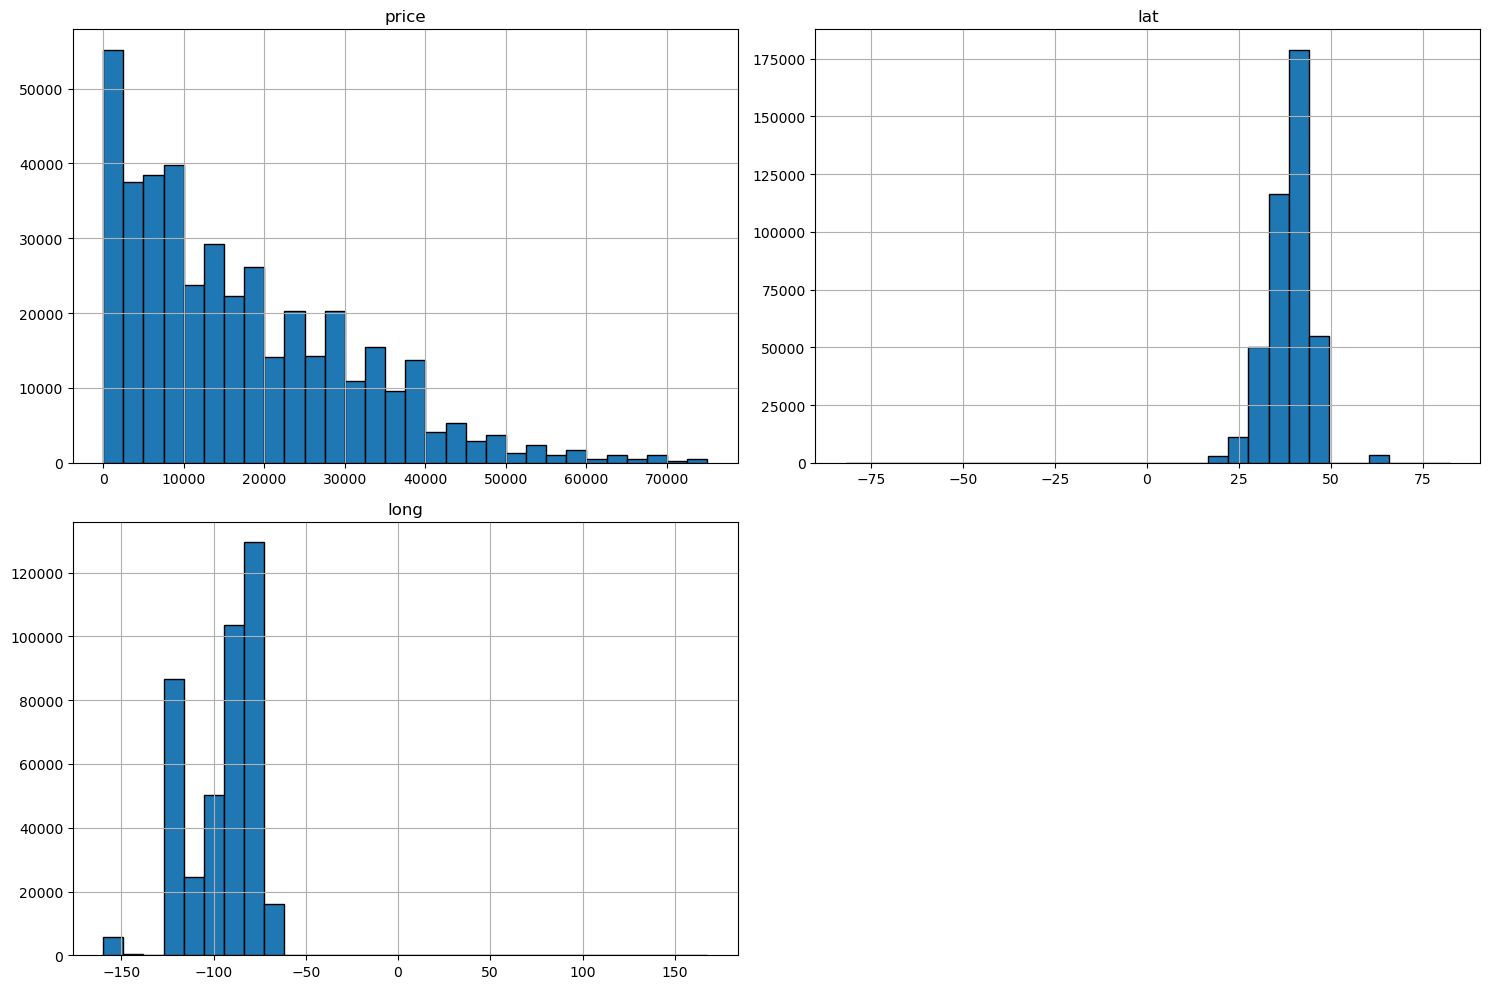

In [134]:
# Assuming 'df' is your pre-existing and cleaned DataFrame

# 1. Select only the numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# 2. Create histograms for all selected columns
#    - figsize sets the overall size of the plot figure.
#    - bins sets the number of bars for each histogram.
#    - edgecolor makes the bars more distinct.
numeric_df.hist(figsize=(15, 10), bins=30, edgecolor='black')

# 3. Adjust the layout to make sure titles and labels don't overlap
plt.tight_layout()

In [135]:
# Select columns with 'object' dtype, which typically stores text
categorical_cols = df.select_dtypes(include=['object']).columns

print("Categorical columns to check:")
print(categorical_cols)

Categorical columns to check:
Index(['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
       'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state',
       'posting_date'],
      dtype='object')


In [136]:
# Loop through each categorical column and print its value counts
for col in categorical_cols:
    print(f"--- Value Counts for: {col} ---")
    print(df[col].value_counts())
    print("\\n" + "="*30 + "\\n")

--- Value Counts for: region ---
columbus               3529
jacksonville           3456
south jersey           2951
stockton               2937
new hampshire          2935
                       ... 
meridian                 23
southwest MS             13
fort smith, AR            9
kansas city               9
west virginia (old)       8
Name: region, Length: 404, dtype: int64
\n==============================\n
--- Value Counts for: manufacturer ---
ford               69527
chevrolet          53603
toyota             34098
honda              21109
nissan             18907
jeep               18817
ram                17176
gmc                16361
Missing            15667
bmw                14541
dodge              13377
mercedes-benz      11548
hyundai            10262
subaru              9445
volkswagen          9240
kia                 8406
lexus               8130
audi                7498
cadillac            6834
chrysler            5986
acura               5931
buick               

In [137]:
# Loop through the categorical columns to clean them
for col in categorical_cols:
    # Remove leading/trailing whitespace
    df[col] = df[col].str.strip()
    # Convert all text to lowercase
    df[col] = df[col].str.lower()

print("All categorical columns have been stripped of whitespace and converted to lowercase.")

All categorical columns have been stripped of whitespace and converted to lowercase.


In [138]:
# Get the number of unique values for each categorical column
unique_counts = df[categorical_cols].nunique()

print("Number of unique values per categorical column:")
print(unique_counts)

Number of unique values per categorical column:
region             404
manufacturer        42
model            27920
condition            7
cylinders            9
fuel                 6
title_status         7
transmission         4
drive                4
type                14
paint_color         13
state               51
posting_date    373056
dtype: int64


In [139]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date
27,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,not_available,pickup,white,al,32.590,-85.480,2021-05-04t12:31:18-0500
28,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,not_available,pickup,blue,al,32.590,-85.480,2021-05-04t12:31:08-0500
29,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,not_available,pickup,red,al,32.590,-85.480,2021-05-04t12:31:25-0500
30,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,not_available,pickup,red,al,32.590,-85.480,2021-05-04t10:41:31-0500
31,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,32.592,-85.519,2021-05-03t14:02:03-0500


In [140]:
import pandas as pd

# --- 1. CONVERT THE COLUMN (with utc=True) ---
# This is the fix:
df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce', utc=True)

# --- 2. *VERIFY* THE CONVERSION ---
# This will now print 'datetime64[ns, UTC]', confirming it worked.
print("--- Data type of 'posting_date' after conversion ---")
print(df['posting_date'].dtype)
print("--------------------------------------------------")

# --- 3. RUN YOUR FORMATTING ---
# The rest of your code will now work perfectly.

# Create YYYY-MM-DD HH:MM:SS string column
# Note: This formatted time will be the UTC equivalent.
df['posting_date_formatted'] = df['posting_date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Create 'Y<YYYY>Q#' quarter column
# This will be based on the standardized UTC date.
quarter_str = df['posting_date'].dt.to_period('Q').astype(str)
df['quarter'] = 'Y' + quarter_str

# Clean up 'YNaT' from any failed conversions
df['quarter'] = df['quarter'].replace('YNaT', pd.NA)

# --- View the results ---
print("\nResulting DataFrame:")
print(df[['posting_date', 'posting_date_formatted', 'quarter']].head())

--- Data type of 'posting_date' after conversion ---
datetime64[ns, UTC]
--------------------------------------------------

Resulting DataFrame:
                posting_date posting_date_formatted  quarter
27 2021-05-04 17:31:18+00:00    2021-05-04 17:31:18  Y2021Q2
28 2021-05-04 17:31:08+00:00    2021-05-04 17:31:08  Y2021Q2
29 2021-05-04 17:31:25+00:00    2021-05-04 17:31:25  Y2021Q2
30 2021-05-04 15:41:31+00:00    2021-05-04 15:41:31  Y2021Q2
31 2021-05-03 19:02:03+00:00    2021-05-03 19:02:03  Y2021Q2


In [141]:
# Get the counts for the 'quarter' column
quarter_counts = df['quarter'].value_counts()

# Sort the counts by the quarter (e.g., Y2021Q1, Y2021Q2)
quarter_counts = quarter_counts.sort_index()

# Print the result
print("Counts per quarter:")
print(quarter_counts)

Counts per quarter:
Y2021Q2    417358
Name: quarter, dtype: int64


In [142]:
# Find the min and max dates
min_date = df['posting_date_formatted'].min()
max_date = df['posting_date_formatted'].max()

# Print the results
print(f"Earliest Posting Date: {min_date}")
print(f"Latest Posting Date:   {max_date}")

Earliest Posting Date: 2021-04-04 07:00:25
Latest Posting Date:   2021-05-05 04:24:09


In [143]:
def coerce_types(raw_df: pd.DataFrame) -> pd.DataFrame:
    df = raw_df.copy()

    # Columns to force as nullable integers
    for col in ["price", "year", "odometer"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

    # posting_date → datetime64[ns], drop tz to be naive, truncate to minutes
    if "posting_date" in df.columns:
        dt = pd.to_datetime(df["posting_date"], errors="coerce", utc=True)
        # Convert to UTC clock time, drop timezone, floor to minute
        df["posting_date"] = dt.dt.tz_convert("UTC").dt.tz_localize(None).dt.floor("min")

    # Everything else as strings
    keep_as_str = [
        "region","manufacturer","model","condition","cylinders","fuel",
        "title_status","transmission","drive","type","paint_color",
        "state","lat","long"
    ]
    for col in keep_as_str:
        if col in df.columns:
            df[col] = df[col].astype("string")

    return df

# Example:
df = coerce_types(df)
df.dtypes  # to verify


region                            string
price                              Int64
year                               Int64
manufacturer                      string
model                             string
condition                         string
cylinders                         string
fuel                              string
odometer                           Int64
title_status                      string
transmission                      string
drive                             string
type                              string
paint_color                       string
state                             string
lat                               string
long                              string
posting_date              datetime64[ns]
posting_date_formatted            object
quarter                           object
dtype: object

In [144]:
def categorical_overview(df: pd.DataFrame, categorical_cols: list[str]) -> pd.DataFrame:
    """
    Build a summary table for categorical features.
    - n_unique: distinct non-missing values.
    - n_missing: number of missing values.
    - value_counts: dict of counts including a '__NA__' bucket for missing.
    """
    rows = []
    for col in categorical_cols:
        if col not in df.columns:
            continue

        s = df[col].astype("string")
        n_unique = s.nunique(dropna=True)
        n_missing = int(s.isna().sum())

        vc = s.value_counts(dropna=False)
        idx = vc.index.to_series().astype(object).where(vc.index.notna(), "__NA__").astype(str)
        value_counts_dict = dict(zip(idx, vc.tolist()))

        rows.append({
            "feature": col,
            "n_unique": n_unique,
            "n_missing": n_missing,
            "value_counts": value_counts_dict
        })

    out = pd.DataFrame(rows).sort_values(["n_unique", "feature"], ascending=[False, True]).reset_index(drop=True)
    return out

# Your categorical feature list (per your schema)
categorical_cols = [
    "region", "manufacturer", "model", "condition", "cylinders", "fuel",
    "title_status", "transmission", "drive", "type", "paint_color", "state",
]

# Example usage:
overview_df = categorical_overview(df, categorical_cols)
overview_df


,feature,n_unique,n_missing,value_counts
0,model,27920,0,"{'f-150': 8035, 'silverado 1500': 5135, '1500'..."
1,region,404,0,"{'columbus': 3529, 'jacksonville': 3456, 'sout..."
2,state,51,0,"{'ca': 49507, 'fl': 27818, 'tx': 22169, 'ny': ..."
3,manufacturer,42,0,"{'ford': 69527, 'chevrolet': 53603, 'toyota': ..."
4,type,14,0,"{'not_available': 88945, 'sedan': 86560, 'suv'..."
5,paint_color,13,0,"{'not_available': 125710, 'white': 77712, 'bla..."
6,cylinders,9,0,"{'6 cylinders': 139170, '4 cylinders': 128809,..."
7,condition,7,0,"{'not_available': 168906, 'good': 119854, 'exc..."
8,title_status,7,0,"{'clean': 396193, 'not_available': 8107, 'rebu..."
9,fuel,6,0,"{'gas': 350247, 'other': 29785, 'diesel': 2759..."


In [145]:
def numeric_describe_table(df: pd.DataFrame, numeric_cols: list[str]) -> pd.DataFrame:
    """
    Returns a DataFrame where each row is a feature
    and columns are the standard .describe() stats + n_missing.
    """
    rows = []
    for col in numeric_cols:
        if col not in df.columns:
            continue
        s = pd.to_numeric(df[col], errors="coerce")
        d = s.describe(percentiles=[0.25, 0.5, 0.75])  # count, mean, std, min, 25%, 50%, 75%, max
        n_missing = int(s.isna().sum())

        rows.append(
            {
                "feature": col,
                "count": float(d.get("count", math.nan)),  # non-missing count
                "n_missing": n_missing,                   # number of NaNs
                "mean": float(d.get("mean", math.nan)),
                "std": float(d.get("std", math.nan)),
                "min": float(d.get("min", math.nan)),
                "25%": float(d.get("25%", math.nan)),
                "50%": float(d.get("50%", math.nan)),
                "75%": float(d.get("75%", math.nan)),
                "max": float(d.get("max", math.nan)),
            }
        )
    out = pd.DataFrame(rows).set_index("feature")
    return out

# Your numeric features per schema
numeric_cols = ["price", "year", "odometer"]   # core numeric
geo_cols = ["lat", "long"]                     # optional numeric (geo)

# Examples:
core_stats = numeric_describe_table(df, numeric_cols)
all_numeric_stats = numeric_describe_table(df, numeric_cols + geo_cols)
display(all_numeric_stats)


,count,n_missing,mean,std,min,25%,50%,75%,max
feature,,,,,,,,,
price,417358.000,0,17057.141,14195.021,0.000,5950.000,13950.000,25995.000,74999.000
year,417358.000,0,2011.422,8.995,1900.000,2008.000,2014.000,2017.000,2022.000
odometer,417358.000,0,90885.552,61601.352,0.000,38561.000,85548.000,132000.000,343862.000
lat,417358.000,0,38.510,5.780,-81.838,34.779,39.150,42.348,82.253
long,417358.000,0,-94.568,18.227,-159.828,-111.800,-88.433,-81.008,167.630


In [146]:
def check_posting_date_missing(df: pd.DataFrame, col: str = "posting_date"):
    # Coerce to datetime (keeps existing tz, treats bad values as NaT)
    s_dt = pd.to_datetime(df[col], errors="coerce", utc=True)

    # Missing mask (NaN/NaT both count as missing)
    missing_mask = s_dt.isna()
    n_missing = int(missing_mask.sum())
    n_total = int(len(s_dt))

    print(f"[posting_date] missing: {n_missing} / {n_total} "
          f"({(n_missing / n_total * 100):.2f}%)")

    if n_missing:
        # Show a few offending raw values for debugging
        bad_samples = (
            df.loc[missing_mask, col]
              .astype("string")
              .value_counts(dropna=False)
              .head(10)
        )
        print("\nTop problematic raw values (up to 10):")
        print(bad_samples)

        # Optional: return indices of rows with missing dates
        return df.index[missing_mask]
    return pd.Index([])

# Example:
bad_idx = check_posting_date_missing(df)
df.loc[bad_idx].head()


[posting_date] missing: 0 / 417358 (0.00%)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417358 entries, 27 to 426879
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   region                  417358 non-null  string        
 1   price                   417358 non-null  Int64         
 2   year                    417358 non-null  Int64         
 3   manufacturer            417358 non-null  string        
 4   model                   417358 non-null  string        
 5   condition               417358 non-null  string        
 6   cylinders               417358 non-null  string        
 7   fuel                    417358 non-null  string        
 8   odometer                417358 non-null  Int64         
 9   title_status            417358 non-null  string        
 10  transmission            417358 non-null  string        
 11  drive                   417358 non-null  string        
 12  type                    41735

In [148]:
print(df.head())

    region  price  year manufacturer                     model  condition  \
27  auburn  33590  2014          gmc  sierra 1500 crew cab slt       good   
28  auburn  22590  2010    chevrolet            silverado 1500       good   
29  auburn  39590  2020    chevrolet       silverado 1500 crew       good   
30  auburn  30990  2017       toyota      tundra double cab sr       good   
31  auburn  15000  2013         ford                 f-150 xlt  excellent   

      cylinders fuel  odometer title_status transmission          drive  \
27  8 cylinders  gas     57923        clean        other  not_available   
28  8 cylinders  gas     71229        clean        other  not_available   
29  8 cylinders  gas     19160        clean        other  not_available   
30  8 cylinders  gas     41124        clean        other  not_available   
31  6 cylinders  gas    128000        clean    automatic            rwd   

      type paint_color state     lat      long        posting_date  \
27  pickup      

# Data Quality Check

In [149]:
# df = pd.read_csv(r'Z:\uncertainty_quantification\datasets\craigslist_cleaned.csv')
# df_bkp = df.copy()

In [150]:
# df = df_bkp.copy()

In [151]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter
27,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,not_available,pickup,white,al,32.59,-85.48,2021-05-04 17:31:00,2021-05-04 17:31:18,Y2021Q2
28,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,not_available,pickup,blue,al,32.59,-85.48,2021-05-04 17:31:00,2021-05-04 17:31:08,Y2021Q2
29,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,not_available,pickup,red,al,32.59,-85.48,2021-05-04 17:31:00,2021-05-04 17:31:25,Y2021Q2
30,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,not_available,pickup,red,al,32.59,-85.48,2021-05-04 15:41:00,2021-05-04 15:41:31,Y2021Q2
31,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,32.592,-85.5189,2021-05-03 19:02:00,2021-05-03 19:02:03,Y2021Q2


In [152]:
# --- Target checks: price ---
price = df["price"]

n_total = len(df)
n_zero = (price == 0).sum()
n_neg = (price < 0).sum()

print(f"Total rows          : {n_total}")
print(f"Rows with price == 0: {n_zero} ({n_zero / n_total:.2%})")
print(f"Rows with price < 0 : {n_neg} ({n_neg / n_total:.4%})")

print("\nprice.describe():")
print(price.describe())

print("\nExtreme quantiles:")
q = price.quantile([0.001, 0.01, 0.99, 0.999])
print(q)


Total rows          : 417358
Rows with price == 0: 32142 (7.70%)
Rows with price < 0 : 0 (0.0000%)

price.describe():
count   417358.000
mean     17057.141
std      14195.021
min          0.000
25%       5950.000
50%      13950.000
75%      25995.000
max      74999.000
Name: price, dtype: Float64

Extreme quantiles:
0.001       0.000
0.010       0.000
0.990   59995.000
0.999   72995.643
Name: price, dtype: Float64


In [153]:
df_cleaned = df[df['price'] > 0]
df_cleaned.shape

(385216, 20)

In [158]:
MIN_YEAR = 1970  # adjust if you want to allow older classics

# Make sure we have posting year handy
df_cleaned['posting_date'] = pd.to_datetime(df_cleaned['posting_date'], errors='coerce', utc=True)
df_cleaned["posting_year"] = df_cleaned["posting_date"].dt.year

invalid_old_year = df_cleaned["year"] < MIN_YEAR
invalid_future_year = df_cleaned["year"] > df_cleaned["posting_year"] + 1

print("Invalid year stats:")
print(f"  year < {MIN_YEAR}: {invalid_old_year.sum()} rows")
print(f"  year > posting_year + 1: {invalid_future_year.sum()} rows")

print("\nExamples: very old year:")
display(df_cleaned[invalid_old_year].head(5))

print("\nExamples: year in the future:")
display(df_cleaned[invalid_future_year].head(5))


Invalid year stats:
  year < 1970: 0 rows
  year > posting_year + 1: 0 rows

Examples: very old year:


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year



Examples: year in the future:


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year


In [159]:
df_cleaned = df_cleaned[df_cleaned['year'] > MIN_YEAR]
df_cleaned.shape

(380642, 21)

In [160]:
df_cleaned.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year
27,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,not_available,pickup,white,al,32.59,-85.48,2021-05-04 17:31:00+00:00,2021-05-04 17:31:18,Y2021Q2,2021
28,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,not_available,pickup,blue,al,32.59,-85.48,2021-05-04 17:31:00+00:00,2021-05-04 17:31:08,Y2021Q2,2021
29,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,not_available,pickup,red,al,32.59,-85.48,2021-05-04 17:31:00+00:00,2021-05-04 17:31:25,Y2021Q2,2021
30,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,not_available,pickup,red,al,32.59,-85.48,2021-05-04 15:41:00+00:00,2021-05-04 15:41:31,Y2021Q2,2021
31,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,32.592,-85.5189,2021-05-03 19:02:00+00:00,2021-05-03 19:02:03,Y2021Q2,2021


In [161]:
# Defensive: avoid div by zero when computing age
age = (df_cleaned["posting_year"] - df_cleaned["year"]).clip(lower=1)

# Miles/km per year
df_cleaned["mileage_per_year"] = df_cleaned["odometer"] / age

MAX_ODOMETER = 500_000    # adjust as needed
MAX_MPY      = 100_000       # suspiciously high mileage/year
MIN_MPY_AGE  = 5            # only flag very low mpy for cars older than this many years
MIN_MPY      = 1_000        # e.g. <1000 miles/year over >5y is suspicious

bad_odo = df_cleaned["odometer"].isna() | (df_cleaned["odometer"] <= 0) | (df_cleaned["odometer"] > MAX_ODOMETER)
bad_high_mpy = df_cleaned["mileage_per_year"] > MAX_MPY
bad_low_mpy = (age > MIN_MPY_AGE) & (df_cleaned["mileage_per_year"] < MIN_MPY)

print("Odometer / mileage-per-year issues:")
print(f"  bad_odo        : {bad_odo.sum()} rows")
print(f"  bad_high_mpy   : {bad_high_mpy.sum()} rows")
print(f"  bad_low_mpy    : {bad_low_mpy.sum()} rows")

print("\nExamples: bad_odo")
display(df_cleaned[bad_odo].head(5))

print("\nExamples: suspiciously high mileage/year")
display(df_cleaned[bad_high_mpy].head(5))

print("\nExamples: suspiciously low mileage/year")
display(df_cleaned[bad_low_mpy].head(5))


Odometer / mileage-per-year issues:
  bad_odo        : 937 rows
  bad_high_mpy   : 29 rows
  bad_low_mpy    : 6493 rows

Examples: bad_odo


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year,mileage_per_year
694,birmingham,3980,2013,kia,rio,not_available,4 cylinders,gas,0,not_available,manual,fwd,sedan,white,al,33.209789,-86.783493,2021-04-24 18:50:00+00:00,2021-04-24 18:50:11,Y2021Q2,2021,0.000
1720,birmingham,10477,2009,chevrolet,colorado,not_available,4 cylinders,gas,0,clean,automatic,not_available,not_available,black,al,33.168322,-87.491902,2021-04-06 13:46:00+00:00,2021-04-06 13:46:53,Y2021Q2,2021,0.000
1804,birmingham,11980,2013,infiniti,g37 sedan,not_available,6 cylinders,gas,0,not_available,automatic,rwd,sedan,silver,al,33.209789,-86.783493,2021-04-04 16:10:00+00:00,2021-04-04 16:10:27,Y2021Q2,2021,0.000
3959,mobile,4500,1997,gmc,sierra,good,6 cylinders,gas,0,clean,automatic,rwd,truck,blue,al,30.663,-88.0556,2021-04-28 12:51:00+00:00,2021-04-28 12:51:45,Y2021Q2,2021,0.000
4267,mobile,4250,1995,ford,f150,good,8 cylinders,gas,0,clean,automatic,rwd,pickup,white,al,30.707577,-88.19676,2021-04-15 02:18:00+00:00,2021-04-15 02:18:18,Y2021Q2,2021,0.000



Examples: suspiciously high mileage/year


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year,mileage_per_year
9738,mohave county,6000,2022,missing,suzuki vitara,not_available,4 cylinders,gas,115000,clean,manual,not_available,not_available,not_available,az,35.2633,-114.0223,2021-04-07 22:56:00+00:00,2021-04-07 22:56:59,Y2021Q2,2021,115000.000
18675,fort smith,59500,2020,ford,f-350 super duty,excellent,8 cylinders,diesel,109000,lien,automatic,4wd,pickup,black,ar,35.3661,-94.1917,2021-04-14 16:32:00+00:00,2021-04-14 16:32:26,Y2021Q2,2021,109000.000
43183,orange county,11990,2022,toyota,4runner 4wd,not_available,6 cylinders,gas,207834,clean,automatic,4wd,not_available,custom,ca,33.694254,-117.846432,2021-04-29 02:16:00+00:00,2021-04-29 02:16:46,Y2021Q2,2021,207834.000
51937,sacramento,1500,2020,missing,2000 ml 430,fair,missing,gas,154000,clean,automatic,4wd,not_available,black,ca,38.6626,-121.4834,2021-05-04 01:33:00+00:00,2021-05-04 01:33:23,Y2021Q2,2021,154000.000
55504,san diego,602,2018,ford,explorer sport,excellent,6 cylinders,gas,336873,not_available,automatic,4wd,suv,not_available,ca,32.837842,-116.966373,2021-05-02 20:03:00+00:00,2021-05-02 20:03:10,Y2021Q2,2021,112291.000



Examples: suspiciously low mileage/year


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year,mileage_per_year
186,birmingham,21250,2002,ford,thunderbird,new,8 cylinders,gas,15996,clean,automatic,fwd,convertible,yellow,al,34.657607,-87.782814,2021-05-04 18:29:00+00:00,2021-05-04 18:29:51,Y2021Q2,2021,841.895
208,birmingham,2500,1976,chevrolet,malibu classic,not_available,4 cylinders,gas,100,clean,automatic,not_available,not_available,not_available,al,33.5179,-86.8372,2021-05-04 12:11:00+00:00,2021-05-04 12:11:30,Y2021Q2,2021,2.222
237,birmingham,20000,1979,chevrolet,malibu,like new,8 cylinders,gas,1234,clean,automatic,rwd,not_available,black,al,33.4653,-86.8082,2021-05-03 16:39:00+00:00,2021-05-03 16:39:01,Y2021Q2,2021,29.381
245,birmingham,5500,1974,mercedes-benz,1929 ssk replica,good,4 cylinders,gas,9999,clean,automatic,rwd,convertible,yellow,al,33.158449,-86.942271,2021-05-03 14:41:00+00:00,2021-05-03 14:41:06,Y2021Q2,2021,212.745
462,birmingham,29950,1998,pontiac,firebird trans am ws6,not_available,8 cylinders,gas,16429,clean,automatic,rwd,hatchback,black,al,37.4011,-77.4615,2021-04-28 21:07:00+00:00,2021-04-28 21:07:48,Y2021Q2,2021,714.304


In [162]:
df_low_odo = df_cleaned[bad_low_mpy]
df_low_odo['odometer'].describe()

count    6493.000
mean     5361.938
std     10047.284
min         0.000
25%         1.000
50%       180.000
75%      6000.000
max     49539.000
Name: odometer, dtype: Float64

In [163]:
df_low_odo.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year,mileage_per_year
186,birmingham,21250,2002,ford,thunderbird,new,8 cylinders,gas,15996,clean,automatic,fwd,convertible,yellow,al,34.657607,-87.782814,2021-05-04 18:29:00+00:00,2021-05-04 18:29:51,Y2021Q2,2021,841.895
208,birmingham,2500,1976,chevrolet,malibu classic,not_available,4 cylinders,gas,100,clean,automatic,not_available,not_available,not_available,al,33.5179,-86.8372,2021-05-04 12:11:00+00:00,2021-05-04 12:11:30,Y2021Q2,2021,2.222
237,birmingham,20000,1979,chevrolet,malibu,like new,8 cylinders,gas,1234,clean,automatic,rwd,not_available,black,al,33.4653,-86.8082,2021-05-03 16:39:00+00:00,2021-05-03 16:39:01,Y2021Q2,2021,29.381
245,birmingham,5500,1974,mercedes-benz,1929 ssk replica,good,4 cylinders,gas,9999,clean,automatic,rwd,convertible,yellow,al,33.158449,-86.942271,2021-05-03 14:41:00+00:00,2021-05-03 14:41:06,Y2021Q2,2021,212.745
462,birmingham,29950,1998,pontiac,firebird trans am ws6,not_available,8 cylinders,gas,16429,clean,automatic,rwd,hatchback,black,al,37.4011,-77.4615,2021-04-28 21:07:00+00:00,2021-04-28 21:07:48,Y2021Q2,2021,714.304


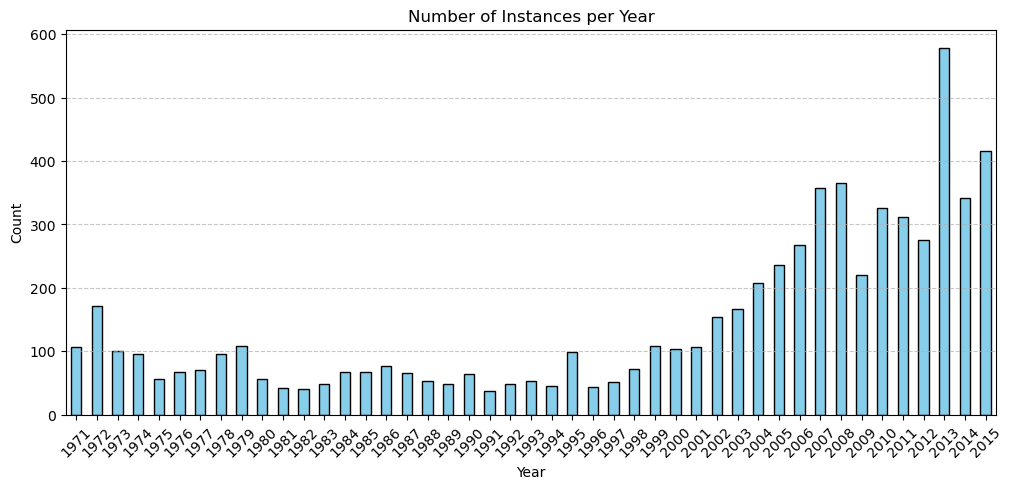

In [164]:
year_counts = df_low_odo['year'].value_counts().sort_index()

plt.figure(figsize=(12,5))
year_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of Instances per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45) # Rotates years for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7) # Optional: Adds gridlines for easier reading

plt.show()

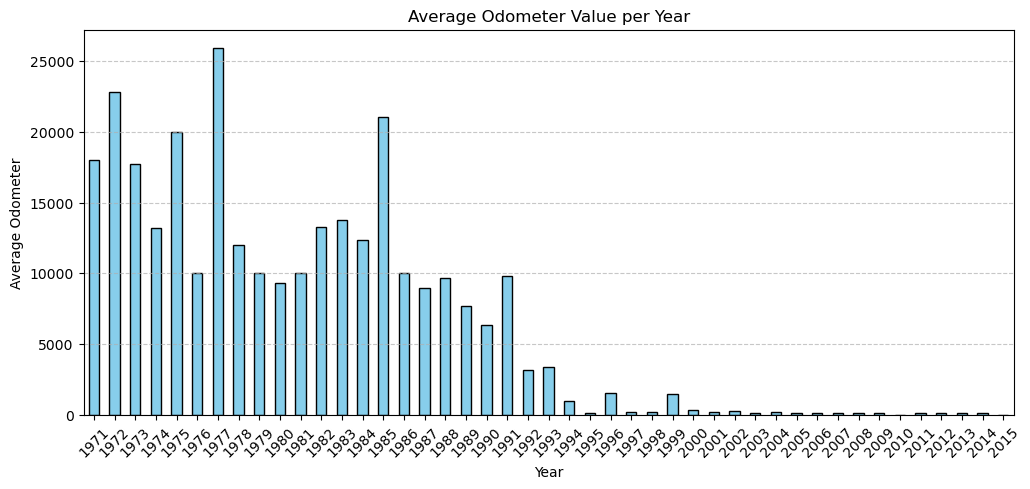

In [165]:
mean_odo_per_year = df_low_odo.groupby('year')['odometer'].median().sort_index()

plt.figure(figsize=(12, 5))

# 2. Plot the calculated means
mean_odo_per_year.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Average Odometer Value per Year')
plt.xlabel('Year')
plt.ylabel('Average Odometer')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [166]:
# Cell: Filter vehicles with suspiciously low mileage (in-place on df_cleaned)


# Work on a copy to avoid side effects during debugging
df = df_cleaned.copy()

# 1) Ensure we have posting_year and compute age + mileage per year
if "posting_year" not in df.columns:
    df["posting_year"] = pd.to_datetime(df["posting_date_formatted"], errors="coerce").dt.year

df["age"] = (df["posting_year"] - df["year"]).clip(lower=1)
df["mileage_per_year"] = df["odometer"] / df["age"]

# 2) Basic odometer sanity + broad low-mpy candidate mask
MAX_ODOMETER = 500_000
LOW_MPY_THRESH = 1_000.0   # broad low-usage candidate
MIN_MPY_AGE = 5            # only care about older cars here
ABS_ODO_MIN = 1_000        # absurdly low total odo for older cars

bad_odo = (
    df["odometer"].isna()
    | (df["odometer"] <= 0)
    | (df["odometer"] > MAX_ODOMETER)
)
low_mpy_candidate = (df["age"] > MIN_MPY_AGE) & (df["mileage_per_year"] < LOW_MPY_THRESH)

# 3) Age-bin specific reference: 10th percentile of mileage_per_year
age_bins = pd.cut(
    df["age"],
    bins=[0, 5, 10, 15, 20, 30, 50, 100],
    include_lowest=True,
    right=True,
)
df["age_bin"] = age_bins

baseline_mask = (~bad_odo) & (df["mileage_per_year"] > 0)
mpy_ref = (
    df.loc[baseline_mask, ["age_bin", "mileage_per_year"]]
      .groupby("age_bin")["mileage_per_year"]
      .quantile(0.10)              # 10th percentile per age bin
      .rename("mpy_q10")
)

df = df.merge(mpy_ref, on="age_bin", how="left")

# 4) Final suspicious-low-mileage mask:
#    - older than MIN_MPY_AGE
#    - total odo < ABS_ODO_MIN
#    - mileage/year below age-specific 10th percentile
suspicious_low_mileage = (
    low_mpy_candidate
    & (df["odometer"] < ABS_ODO_MIN)
    & (df["mileage_per_year"] < df["mpy_q10"])
)

n_before = len(df)
n_drop = int(suspicious_low_mileage.sum())

# 5) Apply filtering and clean helper columns
df_cleaned = (
    df.loc[~suspicious_low_mileage]
      .drop(columns=["age", "mileage_per_year", "age_bin", "mpy_q10"])
      .copy()
)

print(f"Dropped {n_drop} rows ({n_drop / n_before:.2%}) as suspiciously low mileage.")
print(f"Remaining rows in df_cleaned: {len(df_cleaned)}")


Dropped 85 rows (0.02%) as suspiciously low mileage.
Remaining rows in df_cleaned: 380557


In [167]:
categorical_cols = [
    "condition",
    "cylinders",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "type",
    "paint_color",
    "manufacturer",
    "model",
    "state",
    "region",
]

placeholder_tokens = {"not_available", "unknown", "other", "na", "n/a", ""}

for col in categorical_cols:
    print(f"\n=== {col} ===")
    vc = df_cleaned[col].value_counts(dropna=False).head(15)
    print(vc)

    # crude placeholder detection
    mask_placeholder = df_cleaned[col].astype(str).str.lower().isin(placeholder_tokens)
    n_placeholder = mask_placeholder.sum()
    n_missing = df_cleaned[col].isna().sum()
    print(f"  Missing values      : {n_missing}")
    print(f"  Placeholder-ish vals: {n_placeholder}")



=== condition ===
not_available    145377
good             116275
excellent         92162
like new          19343
fair               5879
new                1002
salvage             519
Name: condition, dtype: Int64
  Missing values      : 0
  Placeholder-ish vals: 145377

=== cylinders ===
6 cylinders     128628
4 cylinders     117411
8 cylinders      93814
missing          34393
5 cylinders       2078
other             1693
10 cylinders      1524
3 cylinders        802
12 cylinders       214
Name: cylinders, dtype: Int64
  Missing values      : 0
  Placeholder-ish vals: 1693

=== fuel ===
gas              320259
other             27332
diesel            24013
hybrid             4851
not_available      2510
electric           1592
Name: fuel, dtype: Int64
  Missing values      : 0
  Placeholder-ish vals: 29842

=== title_status ===
clean            360366
not_available      7596
rebuilt            6986
salvage            3696
lien               1361
missing             421
parts only

In [168]:
# Cell: normalize some categorical "misc" categories to 'not_available'

# Work on df_cleaned in place
# Specific mappings you requested:
#   fuel:          'other'   -> 'not_available'
#   title_status:  'missing' -> 'not_available'
#   type:          'other'   -> 'not_available'
#   paint_color:   'custom'  -> 'not_available'
#   manufacturer:  'missing' -> 'not_available'

# Use .replace with column-specific mappings (case-sensitive; adjust if needed)
relabel_map = {
    "fuel":         {"other": "not_available"},
    "title_status": {"missing": "not_available"},
    "type":         {"other": "not_available"},
    "paint_color":  {"custom": "not_available"},
    "manufacturer": {"missing": "not_available"},
}

for col, mapping in relabel_map.items():
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].replace(mapping)

# Quick check: show updated value counts for the edited columns
for col in relabel_map.keys():
    print(f"\n=== {col} (after relabel) ===")
    print(df_cleaned[col].value_counts(dropna=False).head(15))



=== fuel (after relabel) ===
gas              320259
not_available     29842
diesel            24013
hybrid             4851
electric           1592
Name: fuel, dtype: Int64

=== title_status (after relabel) ===
clean            360366
not_available      8017
rebuilt            6986
salvage            3696
lien               1361
parts only          131
Name: title_status, dtype: Int64

=== type (after relabel) ===
not_available    99479
sedan            79319
suv              69858
pickup           39948
truck            29182
coupe            16863
hatchback        15867
wagon             9971
van               7839
convertible       6718
mini-van          4518
offroad            533
bus                462
Name: type, dtype: Int64

=== paint_color (after relabel) ===
not_available    117425
white             71091
black             57176
silver            39588
blue              28529
red               27673
grey              22401
green              6552
brown              6000
yel

In [169]:
# Exact duplicates
n_exact_dups = df_cleaned.duplicated().sum()
print(f"Exact duplicates: {n_exact_dups}")

# Near-duplicates on a key that roughly identifies a car
key_cols = ["region", "state", "manufacturer", "model", "year", "odometer", "price"]
dups_key_mask = df_cleaned.duplicated(subset=key_cols, keep=False)
n_key_dups = dups_key_mask.sum()
print(f"Near-duplicates on key {key_cols}: {n_key_dups}")

print("\nExamples of near-duplicates on key:")
display(df_cleaned[dups_key_mask].sort_values(key_cols).head(10))


Exact duplicates: 0
Near-duplicates on key ['region', 'state', 'manufacturer', 'model', 'year', 'odometer', 'price']: 79002

Examples of near-duplicates on key:


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year
323792,abilene,4500,2002,bmw,x5,not_available,6 cylinders,gas,184000,clean,automatic,not_available,not_available,not_available,tx,32.401556,-99.884713,2021-04-24 14:23:00+00:00,2021-04-24 14:23:17,Y2021Q2,2021
323849,abilene,4500,2002,bmw,x5,not_available,6 cylinders,gas,184000,clean,automatic,not_available,not_available,not_available,tx,32.401556,-99.884713,2021-04-16 14:20:00+00:00,2021-04-16 14:20:53,Y2021Q2,2021
323794,abilene,4000,2004,buick,lesabre,not_available,6 cylinders,gas,113201,clean,automatic,not_available,not_available,not_available,tx,32.401556,-99.884713,2021-04-24 14:21:00+00:00,2021-04-24 14:21:33,Y2021Q2,2021
323851,abilene,4000,2004,buick,lesabre,not_available,6 cylinders,gas,113201,clean,automatic,not_available,not_available,not_available,tx,32.401556,-99.884713,2021-04-16 14:18:00+00:00,2021-04-16 14:18:53,Y2021Q2,2021
323754,abilene,32999,2012,chevrolet,2500,not_available,6 cylinders,diesel,186676,clean,automatic,not_available,not_available,not_available,tx,30.648811,-97.865868,2021-04-29 17:09:00+00:00,2021-04-29 17:09:26,Y2021Q2,2021
323818,abilene,32999,2012,chevrolet,2500,not_available,6 cylinders,diesel,186676,clean,automatic,not_available,not_available,not_available,tx,30.648811,-97.865868,2021-04-21 16:22:00+00:00,2021-04-21 16:22:53,Y2021Q2,2021
323855,abilene,32999,2012,chevrolet,2500,not_available,6 cylinders,diesel,186676,clean,automatic,not_available,not_available,not_available,tx,30.648811,-97.865868,2021-04-15 17:42:00+00:00,2021-04-15 17:42:23,Y2021Q2,2021
323825,abilene,38885,2016,chevrolet,2500,not_available,6 cylinders,diesel,151913,clean,automatic,not_available,not_available,not_available,tx,30.649106,-97.866898,2021-04-21 14:36:00+00:00,2021-04-21 14:36:47,Y2021Q2,2021
323868,abilene,38885,2016,chevrolet,2500,not_available,6 cylinders,diesel,151913,clean,automatic,not_available,not_available,not_available,tx,30.649106,-97.866898,2021-04-14 16:28:00+00:00,2021-04-14 16:28:16,Y2021Q2,2021
323918,abilene,38885,2016,chevrolet,2500,not_available,6 cylinders,diesel,151913,clean,automatic,not_available,not_available,not_available,tx,30.649106,-97.866898,2021-04-05 18:21:00+00:00,2021-04-05 18:21:54,Y2021Q2,2021


In [170]:
key_cols = ["region", "state", "manufacturer", "model", "year", "odometer", "price"]

# mask of rows that belong to some duplicate group
dups_key_mask = df_cleaned.duplicated(subset=key_cols, keep=False)

n_rows_in_dup_groups = int(dups_key_mask.sum())
n_dup_groups = (
    df_cleaned.loc[dups_key_mask, key_cols]
    .drop_duplicates()
    .shape[0]
)

print(f"Rows in duplicate groups: {n_rows_in_dup_groups}")
print(f"Number of duplicate groups (unique car keys): {n_dup_groups}")

print("\nExample duplicate group:")
example_key = (
    df_cleaned.loc[dups_key_mask, key_cols]
    .iloc[0]
    .to_dict()
)
example_mask = (df_cleaned[key_cols] == pd.Series(example_key)).all(axis=1)
display(df_cleaned.loc[example_mask].sort_values("posting_date_formatted"))


Rows in duplicate groups: 79002
Number of duplicate groups (unique car keys): 29913

Example duplicate group:


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year
1315,birmingham,12950,2005,bmw,z4,excellent,6 cylinders,gas,69586,clean,automatic,rwd,convertible,white,al,33.384664,-86.737847,2021-04-10 22:17:00+00:00,2021-04-10 22:17:24,Y2021Q2,2021
138,birmingham,12950,2005,bmw,z4,excellent,6 cylinders,gas,69586,clean,automatic,rwd,convertible,white,al,33.384664,-86.737847,2021-05-04 19:01:00+00:00,2021-05-04 19:01:54,Y2021Q2,2021


In [171]:
# Deduplicate by key_cols, keeping the *latest* posting for each car
# (sort by posting_date_formatted so 'keep="last"' means latest)
key_cols = ["region", "state", "manufacturer", "model", "year", "odometer", "price"]

n_before = len(df_cleaned)

df_cleaned = (
    df_cleaned
    .sort_values("posting_date_formatted")      # earliest → latest
    .drop_duplicates(subset=key_cols, keep="last")
    .reset_index(drop=True)
)

n_after = len(df_cleaned)
n_dropped = n_before - n_after

print(f"Dropped {n_dropped} duplicate rows ({n_dropped / n_before:.2%}) based on key {key_cols}.")
print(f"Rows remaining in df_cleaned: {n_after}")


Dropped 49089 duplicate rows (12.90%) based on key ['region', 'state', 'manufacturer', 'model', 'year', 'odometer', 'price'].
Rows remaining in df_cleaned: 331468


In [172]:
display(df_cleaned.head())
print(df_cleaned.shape)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year
0,hudson valley,18997,2013,dodge,durango,excellent,6 cylinders,gas,96475,clean,automatic,4wd,suv,black,ny,42.598179,-73.708295,2021-04-04 07:00:00+00:00,2021-04-04 07:00:25,Y2021Q2,2021
1,kenosha-racine,119,2013,dodge,dart,excellent,4 cylinders,gas,71800,not_available,automatic,not_available,sedan,not_available,wi,42.595596,-87.879408,2021-04-04 07:03:00+00:00,2021-04-04 07:03:15,Y2021Q2,2021
2,richmond,18937,2011,not_available,forde350,not_available,missing,gas,40000,clean,automatic,not_available,not_available,not_available,va,33.8206,-84.3549,2021-04-04 07:08:00+00:00,2021-04-04 07:08:37,Y2021Q2,2021
3,western slope,38900,2013,not_available,grand caravan,not_available,6 cylinders,not_available,19,clean,automatic,fwd,not_available,black,co,39.674406,-104.998604,2021-04-04 07:10:00+00:00,2021-04-04 07:10:45,Y2021Q2,2021
4,richmond,11750,2013,honda,civic lx,good,4 cylinders,gas,55000,clean,automatic,fwd,not_available,silver,va,37.522967,-77.44473,2021-04-04 07:20:00+00:00,2021-04-04 07:20:50,Y2021Q2,2021


(331468, 21)


In [173]:
# 1. Sort the DataFrame by 'posting_date'
# This reassigns the sorted DataFrame back to the df_cleaned variable
df_cleaned = df_cleaned.sort_values(by='posting_date')


# 2. Create the new 'id' column
# range(df_cleaned.shape[0]) creates a sequence from 0 to (number_of_rows - 1)
# This assigns the sequence based on the new sorted order
df_cleaned['id'] = range(df_cleaned.shape[0])
df_cleaned

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date,posting_date_formatted,quarter,posting_year,id
0,hudson valley,18997,2013,dodge,durango,excellent,6 cylinders,gas,96475,clean,automatic,4wd,suv,black,ny,42.598179,-73.708295,2021-04-04 07:00:00+00:00,2021-04-04 07:00:25,Y2021Q2,2021,0
1,kenosha-racine,119,2013,dodge,dart,excellent,4 cylinders,gas,71800,not_available,automatic,not_available,sedan,not_available,wi,42.595596,-87.879408,2021-04-04 07:03:00+00:00,2021-04-04 07:03:15,Y2021Q2,2021,1
2,richmond,18937,2011,not_available,forde350,not_available,missing,gas,40000,clean,automatic,not_available,not_available,not_available,va,33.8206,-84.3549,2021-04-04 07:08:00+00:00,2021-04-04 07:08:37,Y2021Q2,2021,2
3,western slope,38900,2013,not_available,grand caravan,not_available,6 cylinders,not_available,19,clean,automatic,fwd,not_available,black,co,39.674406,-104.998604,2021-04-04 07:10:00+00:00,2021-04-04 07:10:45,Y2021Q2,2021,3
4,richmond,11750,2013,honda,civic lx,good,4 cylinders,gas,55000,clean,automatic,fwd,not_available,silver,va,37.522967,-77.44473,2021-04-04 07:20:00+00:00,2021-04-04 07:20:50,Y2021Q2,2021,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331464,morgantown,34000,2018,chevrolet,silverado 1500,excellent,8 cylinders,gas,28000,lien,automatic,4wd,truck,white,wv,39.627322,-79.988846,2021-05-05 03:59:00+00:00,2021-05-05 03:59:45,Y2021Q2,2021,331463
331463,seattle-tacoma,16000,1983,chevrolet,c10,good,8 cylinders,gas,35000,clean,automatic,rwd,truck,blue,wa,47.6873,-122.3772,2021-05-05 03:59:00+00:00,2021-05-05 03:59:22,Y2021Q2,2021,331464
331465,milwaukee,4000,2009,toyota,corolla,good,4 cylinders,gas,132000,clean,automatic,fwd,sedan,red,wi,42.9959,-87.9944,2021-05-05 04:07:00+00:00,2021-05-05 04:07:07,Y2021Q2,2021,331465
331466,kenosha-racine,8975,2007,ford,f250 xl 4wd,excellent,8 cylinders,gas,140980,clean,automatic,4wd,pickup,white,wi,42.742896,-88.049852,2021-05-05 04:12:00+00:00,2021-05-05 04:12:08,Y2021Q2,2021,331466


In [176]:
# Final sanity checks before saving

# 1. Make sure there are no non‑positive prices
bad_price_mask = df_cleaned['price'] <= 0
n_bad_price = bad_price_mask.sum()
print("Rows with price <= 0:", n_bad_price)

# If any slipped through for some reason, drop them defensively
if n_bad_price > 0:
    df_cleaned = df_cleaned.loc[~bad_price_mask].copy()
    print("Dropped rows with non‑positive price. New shape:", df_cleaned.shape)

# Optional: tighten other invariants
assert (df_cleaned['price'] > 0).all(), "df_cleaned still has non‑positive prices!"
assert (df_cleaned['year'] > MIN_YEAR).all(), "df_cleaned has years <= MIN_YEAR!"


Rows with price <= 0: 0


In [177]:
df_cleaned.shape

(331468, 22)

In [ ]:
# df_cleaned.to_csv(r"C:\Users\canel\Desktop\craigslist_cleaned.csv", index=False)

In [179]:
df.shape[0]-df_cleaned.shape[0]

49174